# CAR PRICE PREDICTION ANALYSIS
The project develops a machine learning pipeline to estimate the selling prices of used cars.
Given a dirty dataset with confusing outliers, my approach was the  application of Random Forest models on reliable data.

# Import, data analysis and cleaning

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

## Performance analysis function

In [5]:
def regression_performance_report(model, X_test, y_test, show_plot=False):
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    if show_plot:
        fig, ax = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Model Performance Diagnostics', fontsize=16)

        # Plot 1: Actual vs. Predicted
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.4, color='royalblue', ax=ax[0])
        ideal_line = [y_test.min(), y_test.max()]
        ax[0].plot(ideal_line, ideal_line, 'r--', lw=2, label='Perfect Prediction')
        ax[0].set_title('Actual vs. Predicted Price')
        ax[0].set_xlabel('Actual Price (€)')
        ax[0].set_ylabel('Predicted Price (€)')
        ax[0].legend()

        # Plot 2: Distribution of Errors
        residuals = y_test - y_pred
        sns.histplot(residuals, kde=True, color='rebeccapurple', ax=ax[1], kde_kws={'bw_adjust': 2})
        
        # Focus on 98% of the data to remove the "squashing" effect
        lower = np.percentile(residuals, 1)
        upper = np.percentile(residuals, 99)
        ax[1].set_xlim(lower, upper) 
        
        ax[1].set_title('Distribution of Prediction Errors (Zoomed)')
        ax[1].set_xlabel('Error (€)')
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    return pd.Series({'MAE': mae, 'RMSE': rmse, 'R2 Score': r2, 'MAPE (%)': mape})

## Data cleaning

First I had to understand the structure and quality of the dataset.

In [8]:
df = pd.read_csv('auto_price.csv')
print("Shape:", df.shape)
print(df.info())

Shape: (178248, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178248 entries, 0 to 178247
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   price                178248 non-null  int64  
 1   MatriculationMonth   178248 non-null  object 
 2   MatriculationYear    178248 non-null  int64  
 3   km                   146756 non-null  float64
 4   cv                   166933 non-null  float64
 5   FuelType             177485 non-null  object 
 6   gearboxType          177121 non-null  object 
 7   Consume              131811 non-null  object 
 8   city                 178172 non-null  object 
 9   province             178172 non-null  object 
 10  Brand                178087 non-null  object 
 11  Model                178087 non-null  object 
 12  Preparation          178087 non-null  object 
 13  Engine               169898 non-null  float64
 14  Seats                162098 non-null  float64
 1

In [9]:
#Clean 'Consume' (convert "5,4 l/100km" -> 5.4)
# Extract the number and fix the decimal separator
df['Consume'] = df['Consume'].astype(str).str.extract(r'(\d+[\.,]?\d*)')[0]
df['Consume'] = df['Consume'].str.replace(',', '.').astype(float)

# Clean 'NumberDoors'
# 'coerce' turns invalid errors into NaN (empty).
df['NumberDoors'] = pd.to_numeric(df['NumberDoors'], errors='coerce')

# Drop Duplicates
print(f"The duplicates in the dataset were {df.duplicated().sum()}")
df_clean = df.drop_duplicates()

print(f"Rows remaining: {len(df_clean)}")

The duplicates in the dataset were 46417
Rows remaining: 131831


## Analysis and cleaning of the quantitative data

To prevent the model to learn from anomalies and errrors on data, I checked the statistics of the numerical data(floats&integers) to remove the outliers which were not possible according to real-world data.

In [12]:
# Set option to display floats with 2 decimal places (no scientific notation)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# describe table for numerical data
stats = df_clean[['price', 'MatriculationYear', 'km', 'cv', 'Engine', 'Seats', 'ConsumeFuel', 'Emissions']].describe()

print(stats)

           price  MatriculationYear            km        cv    Engine  \
count  131831.00          131831.00     110479.00 123683.00 125913.00   
mean    20089.65            2012.94      91385.86     98.92   1711.08   
std     27103.56               7.04    6461003.34     91.87    778.51   
min       239.00            1900.00          1.00      0.00      1.00   
25%      8990.00            2011.00      16065.50     70.00   1368.00   
50%     15690.00            2015.00      58700.00     85.00   1598.00   
75%     24200.00            2017.00     112334.00    110.00   1995.00   
max   3500000.00            2018.00 2147483647.00  13950.00  96400.00   

          Seats  ConsumeFuel  Emissions  
count 120274.00     91482.00   90794.00  
mean       5.71         5.36     130.82  
std      331.59        19.98      38.87  
min        1.00         0.00       0.00  
25%        5.00         4.10     108.00  
50%        5.00         4.90     119.00  
75%        5.00         5.90     144.00  
max   

The next cell was added because I was removing a lot or rows for the huge amount of Nan values.

In [14]:
#CELL ADDED:
#Create a safe copy
df_clean = df_clean.copy()

# Fill Numeric Columns with Median values/mode
cols_to_fill = ['km', 'cv', 'Engine', 'Emissions', 'ConsumeFuel', 'ConsumeFuelNotUrban', 'Seats']
for col in cols_to_fill:
    if col in df_clean.columns:
        median_val = df_clean[col].median()
        # If the column is entirely empty, fill with 0
        if pd.isna(median_val):
            median_val = 0
        df_clean[col] = df_clean[col].fillna(median_val)

# Fill 'NumberDoors' safely
if 'NumberDoors' in df_clean.columns:
    modes = df_clean['NumberDoors'].mode()
    # Check if a mode exists, otherwise default to 5
    if not modes.empty:
        clean_mode = modes[0]
    else:
        clean_mode = 5.0
    df_clean['NumberDoors'] = df_clean['NumberDoors'].fillna(clean_mode)

#  Verify
print("Missing values remaining:", df_clean.isna().sum().sum())

Missing values remaining: 272514


In [15]:
#Defining realistic ranges
df_filtered = df_clean[
    (df_clean['km'].between(1, 1000000)) &            # Keep cars between 1km and 1m km
    (df_clean['Seats'].between(2, 9)) &               # 2 to 9 seats
    (df_clean['cv'].between(40, 1000)) &              # 40cv to 1000cv
    (df_clean['Engine'] < 8000) &                     # 0cc(electric cars) to 8000cc engine
    (df_clean['ConsumeFuel'] < 30) &                  # Max 30L/100km
    (df_clean['ConsumeFuelNotUrban'] < 30) &          # Max 30L/100km
    (df_clean['Emissions'] < 800) &                   # Max 800g of CO2
    (df_clean['price'].between(500,1000000)) &         # Remove < 500$ cars and >1m$ 
    (df_clean['MatriculationYear'] > 1950)]          #there was a car with mat.year=1900(impossible)
#Add 'CarAge': calculate Age and drop the 'MatriculationYear' column
df_filtered = df_filtered.copy()
df_filtered['CarAge'] = 2026 - df_filtered['MatriculationYear']
df_filtered = df_filtered.drop(columns=['MatriculationYear'])

### Cleaned quantitative data

In [17]:
#Set option to display floats with 2 decimal places (no scientific notation)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# describe table
stats = df_filtered[['price', 'CarAge', 'km', 'cv', 'Engine', 'Seats', 'ConsumeFuel', 'Emissions']].describe()

print(stats)

          price    CarAge        km        cv    Engine     Seats  \
count 130010.00 130010.00 130010.00 130010.00 130010.00 130010.00   
mean   20016.27     12.84  69862.58     97.95   1713.18      4.79   
std    21448.42      6.33  61729.51     49.04    670.89      0.84   
min      500.00      8.00      1.00     40.00      1.00      2.00   
25%     9000.00      9.00  21000.00     70.00   1388.00      5.00   
50%    15800.00     11.00  58700.00     85.00   1598.00      5.00   
75%    24300.00     15.00 100000.00    110.00   1995.00      5.00   
max   999999.00     75.00 999999.00    825.00   7990.00      9.00   

       ConsumeFuel  Emissions  
count    130010.00  130010.00  
mean          5.17     127.26  
std           1.52      32.61  
min           0.00       0.00  
25%           4.40     113.00  
50%           4.90     119.00  
75%           5.30     132.00  
max          29.00     500.00  


Now the numerical data are in realistic ranges and ready  to be anaalysed

### Removal of useless data

I decided to remove some features which were not useful for the analysis, intuitively.

In [21]:
#Drop useless columns:
df_final = df_filtered.drop(columns=['MatriculationMonth','Preparation', 'city','Interior','Color','Consume'], errors='ignore').copy()

## OneHot encoding and Label encoding for the qualitative variables:

I modified this cell to prevent **Data Leakage** by fitting encoders only on the Training set.(I was doing it on the whole sample of data).\
I also implemented a Hybrid Encoding strategy—using Ordinal for brands/models to reduce dimensionality and One-Hot for simpler categories—while adding 'handle_unknown' parameters to ensure the model doesn't crash when it encounters new data in the real world

In [24]:
##CELL MODIFIED:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# 1. SEPARATE INPUTS AND OUTPUTS
# Dropping 'price'(value to predict)
X = df_final.drop(['price'], axis=1, errors='ignore')
y = df_final['price']

# 2. SPLIT BEFORE ENCODING
# Ssplit the data. Encode before splitting, the model might learns from brands/models that only exist in the test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. SORTING COLUMNS BY STRATEGY
# Strategy:
# - Ordinall encoding for Brand,Models,province
ordinal_cols = ['Brand', 'Model', 'province'] 
one_hot_cols = ['FuelType', 'gearboxType', 'EmissionClass', 'Airbag', 'AirConditioning', 'Metallizzato']


ordinal_cols = [c for c in ordinal_cols if c in X_train.columns]
one_hot_cols = [c for c in one_hot_cols if c in X_train.columns]

# 4. ORDINAL ENCODING (For high cardinality features)
# I set 'handle_unknown' to use -1.
# If the Test set has a rare Car Model that wasn't in the Train set,it will just label it as "-1" (meaning "Unknown").
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit on TRAIN, then apply to TEST.
X_train[ordinal_cols] = ord_enc.fit_transform(X_train[ordinal_cols].astype(str))
X_test[ordinal_cols] = ord_enc.transform(X_test[ordinal_cols].astype(str))

# 5. ONE-HOT ENCODING (For low cardinality features)
#'handle_unknown=ignore'.If a new 'FuelType' appears in the future that wasn't in training, this setting ensures the model simply ignores it (sets all columns to 0) instead of crashing.
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

# Learn the categories from TRAIN, then transform both TRAIN and TEST.
train_encoded = ohe.fit_transform(X_train[one_hot_cols])
test_encoded = ohe.transform(X_test[one_hot_cols])

# Convert the raw array back into a readable DataFrame with column names
# Naming the  new columns created through OneHotencoding
ohe_feature_names = ohe.get_feature_names_out(one_hot_cols)
train_encoded_df = pd.DataFrame(train_encoded, columns=ohe_feature_names, index=X_train.index)
test_encoded_df = pd.DataFrame(test_encoded, columns=ohe_feature_names, index=X_test.index)

# 6. MERGE IT ALL BACK TOGETHER
# take the original numeric columns (removing the old text ones) and add to them side-by-side with new One-Hot encoded columns.
X_train_final = pd.concat([X_train.drop(one_hot_cols, axis=1), train_encoded_df], axis=1)
X_test_final = pd.concat([X_test.drop(one_hot_cols, axis=1), test_encoded_df], axis=1)

print("Encoding Complete.")
print(f"Train Shape: {X_train_final.shape}")
print(f"Test Shape:  {X_test_final.shape}")

Encoding Complete.
Train Shape: (104008, 39)
Test Shape:  (26002, 39)


Summary of the Datasets:
df: The raw and unfiltered dataset\
df_clean: make data readable, fixing Consume and NumberDoors, removal of the duplicates\
df_filtered: applied real-world constraints to data, removing the outliers and creation of 'Car Age' from 'Matriculation Year'\
df_final: dropped useless columns(like Color or Interior), converted text data into numbers through Label Encoding and OneHot encoding to apply the ML model.\

# Analysis of the variables

Before building the model it was better to visualize and understand the features which have the  strongest statistical relationship with price; I will use those plots later to select the variables for the model, to use only the relevant ones.

In [28]:
# Calculate correlations with Price
corr_with_price = df_final.corr(numeric_only=True)['price'].sort_values(ascending=True)
corr_with_price = corr_with_price.drop('price')
# Plot a Bar Chart
plt.figure(figsize=(10, 8))
# Use a color palette that maps positive to blue and negative to red
colors = ['blue' if x > 0 else 'red' for x in corr_with_price.values]
corr_with_price.plot(kind='barh', color=colors)

plt.title('Correlation with Price')
plt.xlabel('Correlation Coefficient')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Quick visualization of the top 4 price drivers

The following plots helped to see the non-linear relationships between the most relevant and highly cardinal variables with respect to price.

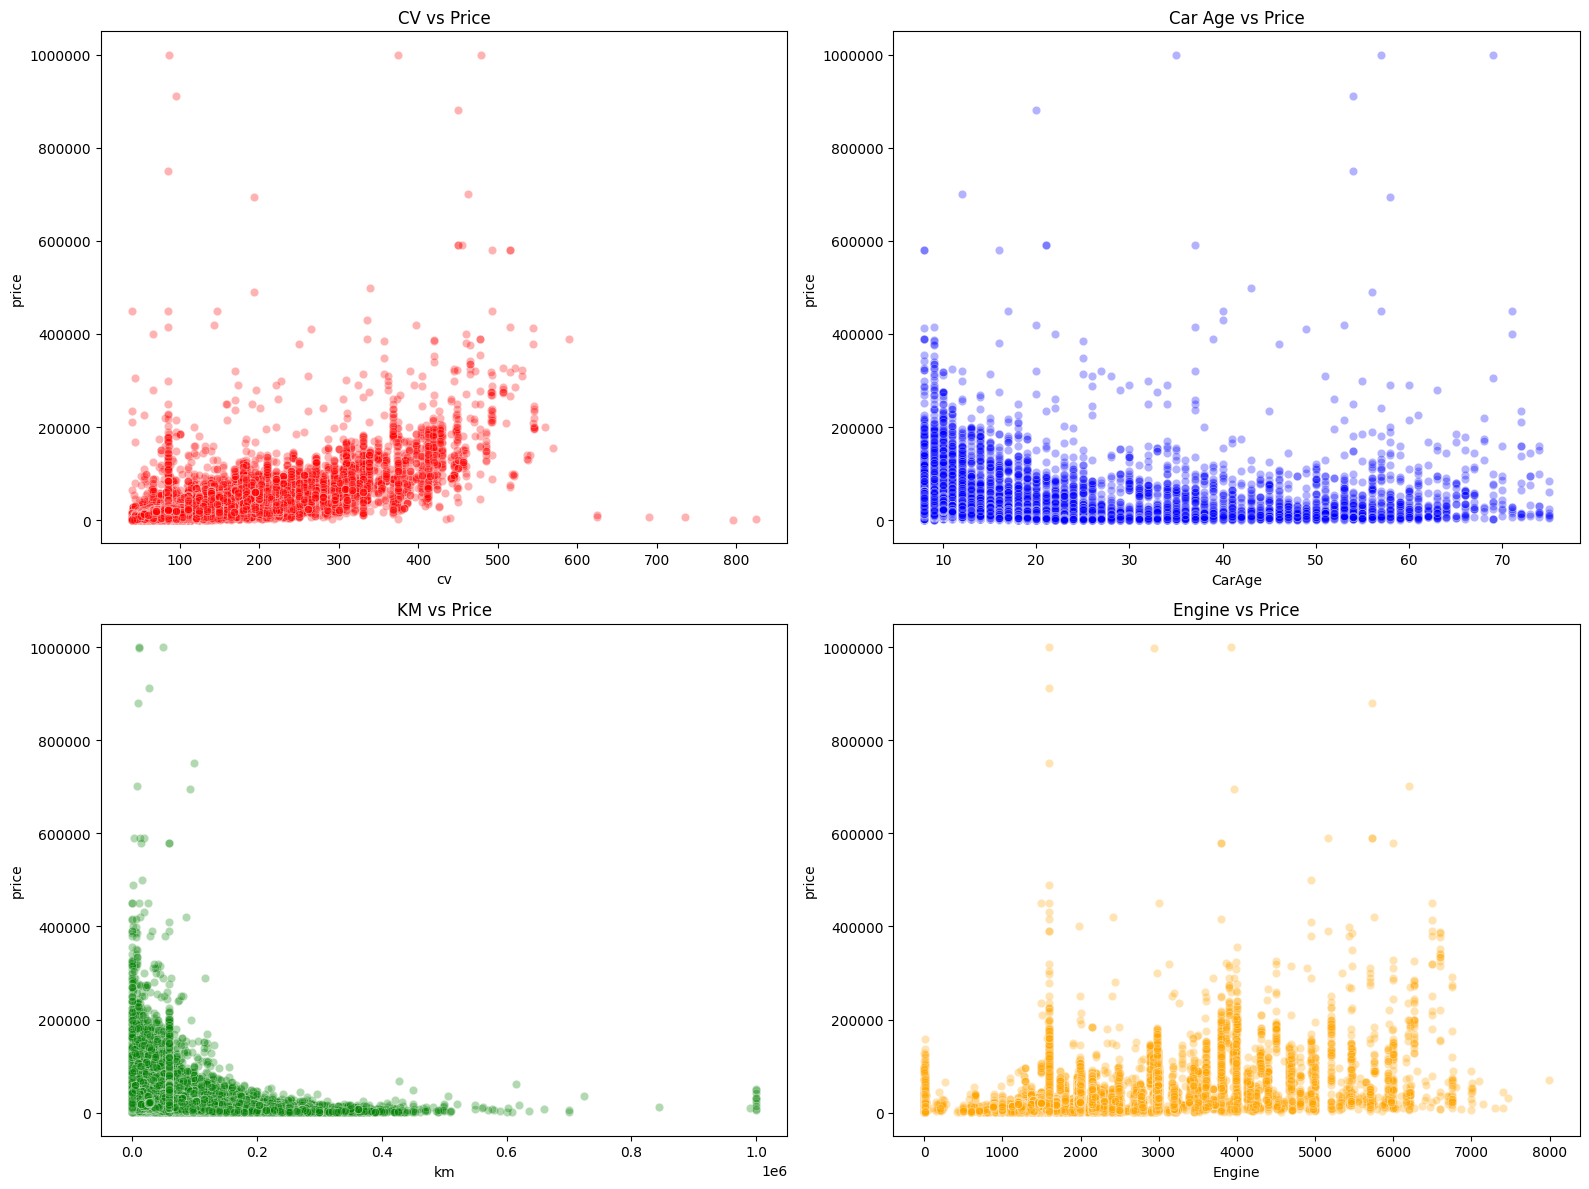

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Power (CV)
sns.scatterplot(x='cv', y='price', data=df_final, alpha=0.3, color='red', ax=axes[0, 0])
axes[0, 0].set_title('CV vs Price')

# 2. Age
sns.scatterplot(x='CarAge', y='price', data=df_final, alpha=0.3, color='blue', ax=axes[0, 1])
axes[0, 1].set_title('Car Age vs Price')

# 3. Usage (KM)
sns.scatterplot(x='km', y='price', data=df_final, alpha=0.3, color='green', ax=axes[1, 0])
axes[1, 0].set_title('KM vs Price')

# 4. Engine Size
sns.scatterplot(x='Engine', y='price', data=df_final, alpha=0.3, color='orange', ax=axes[1, 1])
axes[1, 1].set_title('Engine vs Price')
#To remove the scientific notation
for ax in axes.flat:
    ax.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

# Random Forest with all the features of df_final(30 variables)

In [33]:
df_final

price        km     cv FuelType        gearboxType province  \
0       15500  82914.00  85.00   Diesel  Cambio automatico   Modena   
1        3900 161038.00  75.00  Benzina     Cambio manuale   Modena   
2       15900 114830.00  80.00   Diesel     Cambio manuale   Modena   
3       54900  61700.00 183.00   Diesel  Cambio automatico   Padova   
4       45900  25790.00 190.00   Diesel  Cambio automatico   Padova   
...       ...       ...    ...      ...                ...      ...   
143981  22950  28000.00 110.00   Diesel     Cambio manuale  Bologna   
143982  23950  27000.00 110.00   Diesel  Cambio automatico  Bologna   
143983  23500  28000.00  85.00   Diesel     Cambio manuale  Bologna   
143984  20950  27000.00  85.00   Diesel  Cambio automatico  Bologna   
143985  23950  29000.00 110.00   Diesel  Cambio automatico  Bologna   

                Brand     Model  Engine  Seats  ConsumeFuel  \
0                 BMW   Serie 1 1995.00   5.00         4.10   
1          VOLKSWAGEN      Golf 1595.00   5.00         7.20   
2       MERCEDES BENZ  Classe A 1461.00   5.00         3.80   
3                 BMW        X5 2993.00   5.00         5.90   
4                 BMW        X5 2993.00   5.00         6.20   
...               ...       ...     ...    ...          ...   
143981            BMW   Serie 2 1995.00   5.00         4.10   
143982            BMW   Serie 2 1995.00   5.00         4.10   
143983            BMW   Serie 2 1496.00   5.00         3.80   
143984            BMW   Serie 2 1496.00   5.00         3.80   
143985            BMW   Serie 2 1995.00   5.00         4.10   

        ConsumeFuelNotUrban  Emissions Metallizzato  \
0                      3.60     109.00          NaN   
1                      5.60     176.00          NaN   
2                      3.30      98.00          NaN   
3                      5.50     156.00          NaN   
4                      5.70     162.00           Sì   
...                     ...        ...          ...   
143981                 3.70     109.00           Sì   
143982                 3.70     109.00           Sì   
143983                 3.40      99.00          NaN   
143984                 3.40      99.00           Sì   
143985                 3.70     109.00          NaN   

                                             Airbag  NumberDoors  \
0                                               NaN         5.00   
1                                               NaN         5.00   
2                                               NaN         5.00   
3                                               NaN         5.00   
4                                               NaN         5.00   
...                                             ...          ...   
143981  Airbag anteriori e laterali e di altro tipo         5.00   
143982  Airbag anteriori e laterali e di altro tipo         5.00   
143983  Airbag anteriori e laterali e di altro tipo         5.00   
143984  Airbag anteriori e laterali e di altro tipo         5.00   
143985  Airbag anteriori e laterali e di altro tipo         5.00   

       EmissionClass            AirConditioning  CarAge  
0                NaN                        NaN      13  
1                NaN                        NaN      20  
2                NaN                        NaN      12  
3                NaN                        NaN      10  
4                NaN                        NaN      12  
...              ...                        ...     ...  
143981        Euro 6  Climatizzatore automatico      10  
143982        Euro 6  Climatizzatore automatico      10  
143983        Euro 6  Climatizzatore automatico      10  
143984        Euro 6  Climatizzatore automatico      10  
143985        Euro 6  Climatizzatore automatico      10  

[130010 rows x 19 columns]

## MODEL TRAINING & EVALUATION

In [35]:
#Prepare Data
# remove the target 'price' to create the Feature Matrix (X) and Target Vector (y)
X = df_final.drop(columns=['price'])
y = df_final['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
# Training a Random Forest with 100 trees (using all CPU cores, n_jobs=-1)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_final, y_train)

# Predict & Score
predictions = rf_model.predict(X_test_final)
baseline_stats = regression_performance_report(rf_model, X_test_final, y_test, show_plot=True)
print("  Baseline Model Scorecard ")
print(baseline_stats)

  Baseline Model Scorecard 
MAE        2337.70
RMSE       9325.65
R2 Score      0.82
MAPE (%)     16.03
dtype: float64


High RMSE= significant errors in the outliers

In [37]:
# Check Training Score: Did the model learn the patterns? 
print(f"Train Score: {rf_model.score(X_train_final, y_train):.4f}")

# Check Test Score: Real-world accuracy on new dataset
# If Train is High (0.99) but Test is Low (0.70) = Overfitting.
# If both are High (0.99 and 0.96) = Great Model.
print(f"Test Score:  {rf_model.score(X_test_final, y_test):.4f}")
print('Train score: how the model has learned from data')
print('Test score: how much variance can capture the model with unseen data')

Train Score: 0.9692
Test Score:  0.8226
Train score: how the model has learned from data
Test score: how much variance can capture the model with unseen data


Good generalization of the results, the model learned the logics behind the car prices, leading to a good price estimation pattern./
However, the model uses 30 variables, which introduce unnecessary complexity. I have to perform an optimization of the  parameters.

In [39]:
# Feature importance - Mean Decrease in Impurity (MDI)
# Extract importances from the trained Random Forest
importances = pd.Series(rf_model.feature_importances_, index=X_train_final.columns)

#Sort them
sorted_importances = importances.sort_values(ascending=False)

#  Visualize the results
plt.figure(figsize=(12, 8))
sorted_importances.plot(kind='barh', color='teal')
plt.title('Feature Importance: Which variables drive the Price?')

#Mean Decrease in Impurity
plt.xlabel('Importance Score (Mean Decrease in Impurity)') 

plt.gca().invert_yaxis() # Highest importance at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

To solve overfitting issues, I am moving toward a more accurate, less complex model that prioritizes high-signal features identified through Mean Decrease in Impurity (MDI).\
This ranking system allows me to quantify exactly how much each feature reduces the variance of the car prices across all trees in the forest.\
By discarding the insignificant features and focusing on high-impact variables, I am reducing the risk of the model 'memorizing' irrelevant data points.\
I am removing the statistical noise that leads to overfitting.\
This ensures the model focuses strictly on the true drivers of market value.\
Ultimately, this optimization improves the model's ability to generalize, ensuring that the logic learned during training remains highly accurate when applied to new cars in the real-world market.

# Random forest with the 7 most influential features

The 7 features were selected using the previous plot, considering the MDI score\
The steps performed are:\
1.Selection of the variables\
2.Split into train and test the dataset\
3.K-cross-validation of the model\
4.Train the model on the training set\
5.Evaluation of the accuracy

In [43]:
# Feature Selection
top_7_features = ['cv', 'CarAge', 'km', 'Brand', 'Model', 'Engine', 'Emissions']

#Slice the already encoded training data
# use .copy() to avoid warnings
X_train7 = X_train_final[top_7_features].copy()
X_test7  = X_test_final[top_7_features].copy()

# Use the y_train/y_test that we already defined in the Encoding Step
y_train7 = y_train
y_test7  = y_test

# Training
rf_7 = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Stability Check (CV)
cv_scores_7 = cross_val_score(rf_7, X_train7, y_train7, cv=5, scoring='r2')

# Fit the model
rf_7.fit(X_train7, y_train7)

# Evaluation
print("7 Vars Performance:")
print(f"Mean CV R2: {cv_scores_7.mean():.4f} Std Dev: {cv_scores_7.std():.4f}")

stats_7 = regression_performance_report(rf_7, X_test7, y_test7, show_plot=True)
print(stats_7)

7 Vars Performance:
Mean CV R2: 0.7806 Std Dev: 0.0233


MAE        2413.65
RMSE       9287.80
R2 Score      0.82
MAPE (%)     16.54
dtype: float64


To refine the model, I reduced the complexity from 30 variables to the 7 most impactful features—['cv', 'CarAge', 'km', 'Brand', 'Model', 'Engine', 'Emissions'] based on their MDI (Mean Decrease in Impurity) ranking.\
By isolating these predictors, I stripped away the statistical noise responsible for overfitting.\
I then implemented 5-fold cross-validation to ensure the model's stability, which returned a consistent Mean R2.\
The model statistics prove that I maintained high predictive power while creating a much leaner, more generalized tool that focuses strictly on the primary economic drivers of car value.

# Random Forest with only the 5 most influential features

I selected the  ['cv', 'CarAge', 'km', 'Brand', 'Engine'] to avoid high cardinality and overfitting,  chosen following the correlation chart above.

In [47]:
# Feature Selection
top_5_features = ['cv', 'CarAge', 'km', 'Brand', 'Engine']

# Slice the already encoded training data
# select these 5 columns from the variables prepared in the Encoding Step
X_train5 = X_train_final[top_5_features].copy()
X_test5  = X_test_final[top_5_features].copy()

# Use the y_train/y_test
y_train5 = y_train
y_test5  = y_test

# Training
rf_5 = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Stability Check
cv_scores_5 = cross_val_score(rf_5, X_train5, y_train5, cv=5, scoring='r2')

# Fit the model
rf_5.fit(X_train5, y_train5)

# Evaluation
print("5 Vars Performance:")
print(f"Mean CV R2: {cv_scores_5.mean():.4f} Std Dev: {cv_scores_5.std():.4f}")

stats_5 = regression_performance_report(rf_5, X_test5, y_test5, show_plot=True)
print(stats_5)

Running Cross-Validation on 5 variables...
5 Vars Performance:
Mean CV R2: 0.7721 Std Dev: 0.0250


MAE        2903.71
RMSE       9785.96
R2 Score      0.80
MAPE (%)     18.91
dtype: float64


## Model comparison

In [49]:
comparison_df = pd.DataFrame({
    "Metric": ["Test R2 Score", "MAE (Euro Error)", "CV Stability (Std Dev)", "Variables"],
    "Baseline": [baseline_stats['R2 Score'], f"€{baseline_stats['MAE']:.2f}", "Not performed", 30],
    "Model 7 ": [stats_7['R2 Score'], f"€{stats_7['MAE']:.2f}", f"{cv_scores_7.std():.4f}", 7],
    "Model 5 ": [stats_5['R2 Score'], f"€{stats_5['MAE']:.2f}", f"{cv_scores_5.std():.4f}", 5]
})

print("COMPARISON")
print(comparison_df.to_string(index=False))

COMPARISON
                Metric      Baseline Model 7  Model 5 
         Test R2 Score          0.82     0.82     0.80
      MAE (Euro Error)      €2337.70 €2413.65 €2903.71
CV Stability (Std Dev) Not performed   0.0233   0.0250
             Variables            30        7        5


Based on the final comparison, I have selected Model 7 as the optimal predictor for car prices.
The model with 7 variables offered the best tradeoff between high accuracy and low complexity.\
The model with 30 features shows the lowest absolute error, but the risk of overfitting the data is high.\
The model with 7 variables instead allowed me to keep the same R2 score while reducing the feature set, with a negligible increase in the absolute mean error.\
The model  with 5 features showed a high MAE, suggesting that by removing 'Model' and 'Emissions' variables the predictor gained inaccuracy, leading to thhe conclusion that the 5-features models was an oversimplification\
I decided to keep the 7-features model valid for the Hyperparameter optimization.

# Optimization

The optimization of the hyperparameters is a fundamental step to find the best configuration for the  Random Forest to be more precise and leaner.\
I ran the optimization on the model with 7 variables.

In [53]:
# HYPERPARAMETER TUNING (Add/Remove Complexity)
#  max_depth: Controls how "deep" the trees grow (complexity)
#  n_estimators: Number of trees (stability)
#  min_samples_split: Controls overfitting (higher = simpler model)
param_grid = {
    'n_estimators': [50,100, 200],       # Try more trees
    'max_depth': [10, 20, 30],              # 10 = restricted (simple)
    'min_samples_split': [2, 5, 10],        # Higher numbers prevent overfitting
    'min_samples_leaf': [1, 2, 4],          # Higher numbers simplify the model
    'max_features': ['sqrt', None]  # 'sqrt'=look only to some random features,None uses all features
}

## Optimization of the parameters for the Random Forest

In [55]:
# The 80/20 Split
top_7_features = ['cv', 'CarAge', 'km', 'Brand', 'Model', 'Engine', 'Emissions']

# Create the 7-variable datasets by selecting columns from the FINAL encoded data
X_train7 = X_train_final[top_7_features].copy()
X_test7  = X_test_final[top_7_features].copy()

# y_train and y_test are ready from the Encoding step
y_train7 = y_train
y_test7  = y_test
#take a 10% random sample of the training set to speed up the search
X_tune7 = X_train7.sample(frac=0.1, random_state=42)
y_tune7 = y_train7.loc[X_tune7.index]
# Setting up the search grid to find the perfect balance between accuracy and simplicity
rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_grid,
    n_iter=10, 
    cv=3, 
    random_state=42,
    n_jobs=-1,
    verbose = 1
)

rf_random.fit(X_tune7, y_tune7)
print(f"Best Parameters found: {rf_random.best_params_}")

# Stability Check (Cross-Validation)
#K-Fold Cross-Validation.
final_model_7 = RandomForestRegressor(**rf_random.best_params_, random_state=42, n_jobs=-1)

cv_scores_7 = cross_val_score(final_model_7, X_train7, y_train7, cv=5, scoring='r2')

print(f"  Stability Report")
print(f"Average R2 across 5 folds: {cv_scores_7.mean():.4f}")
print(f"Stability (Std Dev): {cv_scores_7.std():.4f}") 

# Final Training
# Now the model runs on the full 80% training set using the best parameters.
final_model_7.fit(X_train7, y_train7)

# Final Evaluation
# Testing the model on test set
print(f"FINAL EVALUATION ON TEST DATA")
final_results_7 = regression_performance_report(final_model_7, X_test7, y_test7, show_plot=True)

print(final_results_7)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters found: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
  Stability Report
Average R2 across 5 folds: 0.8010
Stability (Std Dev): 0.0296
FINAL EVALUATION ON TEST DATA


MAE        2389.44
RMSE       9023.57
R2 Score      0.83
MAPE (%)     16.55
dtype: float64


Mean R2 vs Final R2:
Stability: model is quite stable

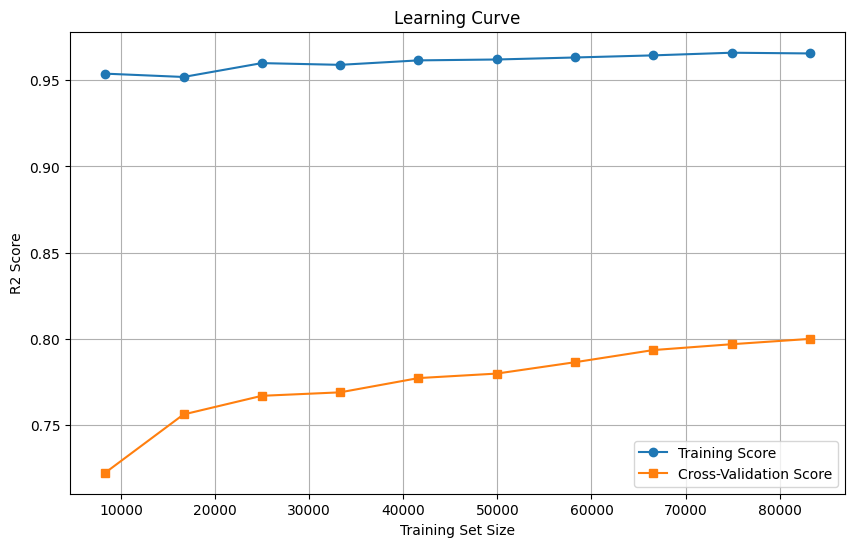

In [57]:
from sklearn.model_selection import learning_curve

# Generate data for the Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    final_model_7, X_train7, y_train7, cv=5, 
    scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate means and standard deviations
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', marker='o')
plt.plot(train_sizes, test_mean, label='Cross-Validation Score', marker='s')

plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('R2 Score')
plt.legend()
plt.grid(True)
plt.show()

The convergence of the training and validation scores indicates a well-optimized model, managing the tradeoff betweeen bias and variance.\
The high level of the R2 stabilizes (in the cross-validation), meaning that from 35 thousand observations and the accuracy of the model is not improved.

# Gradient Boosting

In [60]:
# TESTING XGBOOST (GRADIENT BOOSTING)

# I'm testing XGBoost to see if it can beat the Random Forest.
#While RF builds trees in parallel, XGBoost builds them one by one, where each new tree tries to fix the residuals of the previous one.

# 1. Initialize the XGBoost Regressor
# I'm using a low learning rate (0.05) to make the learning more precise.
xgb_model = XGBRegressor(
    n_estimators=200,     
    learning_rate=0.05, 
    max_depth=6,          # XGBoost usually prefers less trees than Random Forest
    subsample=0.8,        # Using 80% of data per tree to prevent overfitting
    colsample_bytree=0.8, 
    n_jobs=-1, 
    random_state=42
)

# 2. Fit the model on the 7-variable training set
xgb_model.fit(X_train7, y_train7)

# 3. Predict and Score
xgb_preds = xgb_model.predict(X_test7)

# use the same regression report
xgb_results = regression_performance_report(xgb_model, X_test7, y_test7, show_plot=True)


print("XGBOOST PERFORMANCE REPORT")
print(xgb_results)

# 4.XGBoost vs. Optimized Random Forest
# compare the R2 score of this XGBoost againstthe optimized Random forest
rf_r2 = final_results_7['R2 Score']
xgb_r2 = xgb_results['R2 Score']


print(f"Random Forest R2: {rf_r2:.4f}")
print(f"XGBoost R2:       {xgb_r2:.4f}")


if xgb_r2 > rf_r2:
    improvement = (xgb_r2 - rf_r2) / rf_r2 * 100
    print(f"RESULT: XGBoost won by {improvement:.2f}%! It's new best model.")
else:
    print("RESULT: Random Forest is better")

XGBOOST PERFORMANCE REPORT
MAE        3130.98
RMSE       9814.75
R2 Score      0.80
MAPE (%)     21.00
dtype: float64
Random Forest R2: 0.8339
XGBoost R2:       0.8035
RESULT: Random Forest is better


# Visualization of some decision trees

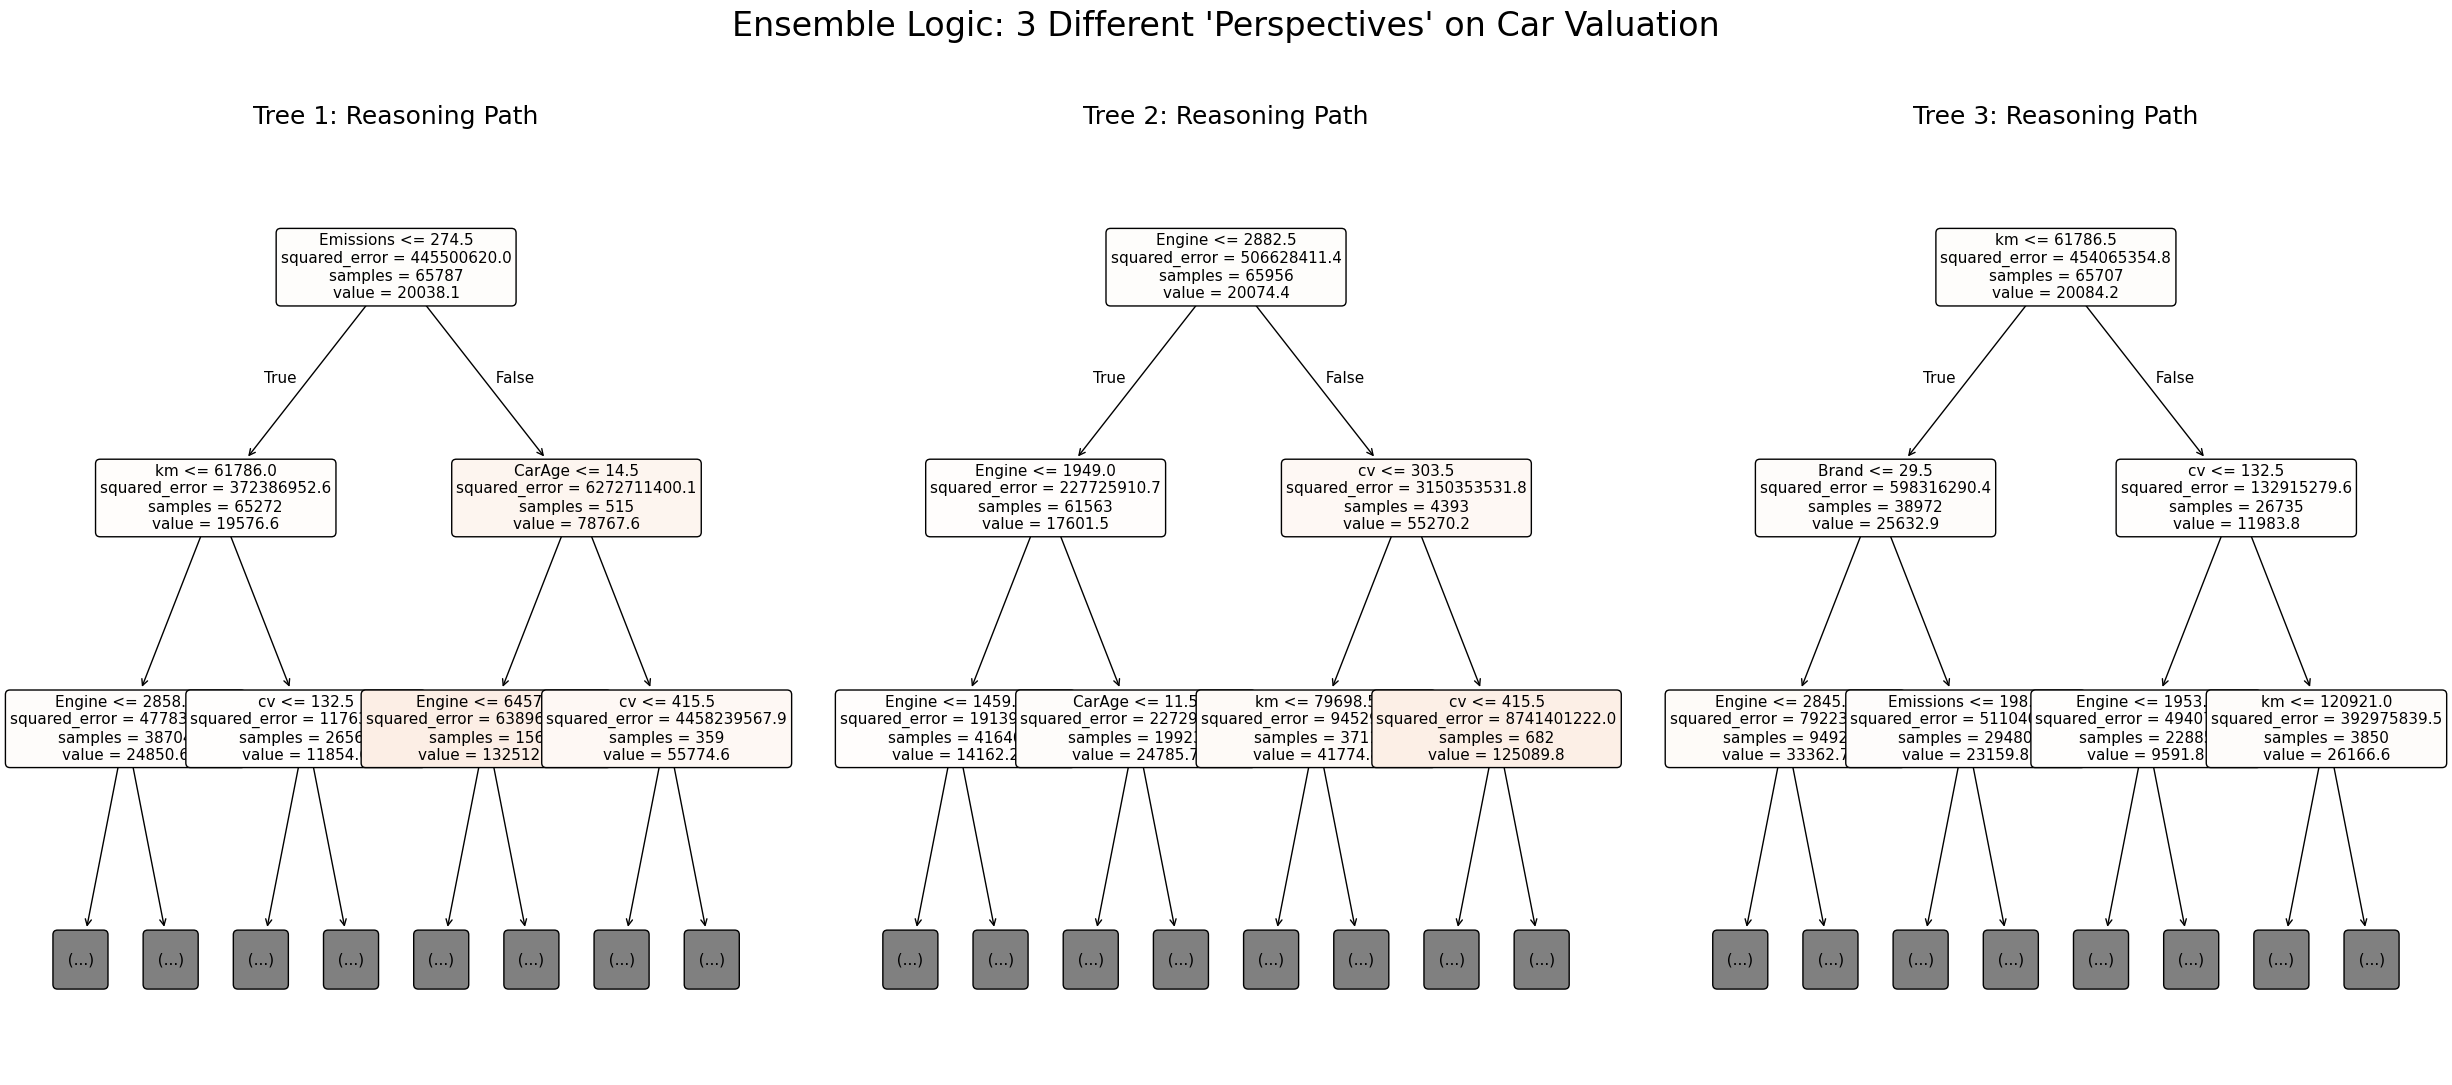

In [62]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# 1. Setup the figure grid (1 row, 3 columns)
# We use a wide layout so each tree has space to breathe
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 10))

# 2. Loop through the first 3 trees of the optimized Random Forest
for i in range(3):
    # Select the trees
    tree_to_plot = final_model_7.estimators_[i]
    
    # Plotting logic
    plot_tree(tree_to_plot, 
              feature_names=top_7_features, 
              max_depth=2,       # Keeping it at 2 for a clear  view of the logic
              filled=True,       # Colors indicate the predicted price level
              precision=1, 
              rounded=True, 
              fontsize=11,
              ax=axes[i])
    
    axes[i].set_title(f"Tree {i+1}: Reasoning Path", fontsize=18, pad=20)

# 3. Final visual adjustments
plt.tight_layout()
plt.suptitle("Ensemble Logic: 3 Different 'Perspectives' on Car Valuation", 
             fontsize=24, y=1.08)
plt.show()

This visualization shows the first 3 decision trees from the optimized Random Forest composed by 7 variables; 
Each tree is trained on a random subset of data and features, leading to diverse 'perspectives' on car valuation
The diversity on the focus of each tree leads to a reduction of noise and by averaging all the responses of the 100 trees the model achieves high stability and predictability power

# Price estimator

In [ ]:
print("CAR PRICE PREDICTOR")
# 1. BRAND SELECTION
user_brand = input("Insert Brand: ").strip().lower()
available_brands = df_filtered['Brand'].str.lower().unique()

if user_brand in available_brands:
    brand_models = df_filtered[df_filtered['Brand'].str.lower() == user_brand]['Model'].unique()
    brand_models = sorted([str(m) for m in brand_models])
    print(f" Available models for {user_brand.upper()}:")
    print(", ".join(brand_models))
    user_model = input(" Model from the list above:").strip().lower()
    if user_model not in [m.lower() for m in brand_models]:
        print(f"Model not recognized. Using the most common {user_brand} model instead.")
        user_model = df_filtered[df_filtered['Brand'].str.lower() == user_brand]['Model'].mode()[0].lower()
else:
    print("Brand not found. Using general market averages.")
    user_brand = df_filtered['Brand'].mode()[0].lower()
    user_model = df_filtered['Model'].mode()[0].lower()

# 2. RECONSTRUCTING MAPPINGS
brand_map = dict(zip(X_train['Brand'].astype(str).str.lower(), X_train_final['Brand']))
model_map = dict(zip(X_train['Model'].astype(str).str.lower(), X_train_final['Model']))

brand_id = brand_map.get(user_brand, -1)
model_id = model_map.get(user_model, -1)

# 3. TECHNICAL SPECS

print("Please enter specs (Press Enter for typical values):")

# Defaults from Training Data
def_cv = X_train_final['cv'].median()
def_age = X_train_final['CarAge'].median()
def_km = X_train_final['km'].median()
def_eng = X_train_final['Engine'].median()
def_emi = X_train_final['Emissions'].median()

cv_in = input(f"- Horsepower (CV) [Default {def_cv}]: ").strip()
cv = float(cv_in) if cv_in else def_cv

age_in = input(f"- Car Age in years [Default {def_age}]: ").strip()
age = float(age_in) if age_in else def_age

km_in = input(f"- Kilometers [Default {def_km}]: ").strip()
km = float(km_in) if km_in else def_km

eng_in = input(f"- Engine size (cc) [Default {def_eng}]: ").strip()
engine = float(eng_in) if eng_in else def_eng

em_in = input(f"- Emissions of CO2 [Default {def_emi}]: ").strip()
emissions = float(em_in) if em_in else def_emi

# 4. PREDICTION
input_df = pd.DataFrame({
    'cv': [cv], 
    'CarAge': [age], 
    'km': [km], 
    'Brand': [brand_id], 
    'Model': [model_id], 
    'Engine': [engine], 
    'Emissions': [emissions]
})

# Make the prediction
predicted_price = final_model_7.predict(input_df)[0]

print(f"ESTIMATED MARKET PRICE: € {predicted_price:.2f}")

CAR PRICE PREDICTOR
